In [12]:
import pandas as pd
import numpy as np
import PIL
import os
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
DATA_PATH = './data/'

# using typical split of 70:20:10
SIZE_OF_VALIDATION_SET = 0.2
SIZE_OF_TEST_SET = 0.1

In [3]:
df = pd.read_parquet(DATA_PATH + 'test_catalog.parquet')

In [4]:
# if necessary, change path to the location of the images and masks
df['spiral_mask_loc'] = df['spiral_mask_loc'].str.replace('/Users/user/repos/zoobot-3d/data/gz3d/', '')
df['bar_mask_loc'] = df['bar_mask_loc'].str.replace('/Users/user/repos/zoobot-3d/data/gz3d/', '')
df['desi_jpg_loc'] = df['desi_jpg_loc'].str.replace('/Users/user/repos/zoobot-3d/data/desi/', '')

In [5]:
df_convert = (df
    [['brickid', 'objid', 'spiral_mask_loc', 'bar_mask_loc', 'desi_jpg_loc', 'spiral_mask_exists']]
    .assign(object_id = lambda _df: _df.brickid.astype(str) + _df.objid.astype(str))
)

In [8]:
def bbox(img):
    """
      Takes an image/array and returns the coordinates
      of the the bounding box around all values != 0.

      Returns:
        rmin, rmax, cmin, cmax for y1, y2, x1, x2
    """
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    return rmin, rmax, cmin, cmax

In [ ]:
# Mask R-CNN needs binary masks.
# As such the volunteers' polygons are condensed into a single binary array.

# only for documentation, not used here
class_labels = {
    'background': 0,
    'spiral_arm': 1,
    'bar': 2,
}

# todo: needs refinement
# only pixels of the masks greater than threshold are kept
# 50 represents at least 3 volunteers' markings
px_threshold = 50

# empty list for records
# format: mask_id, bbox_xmax, bbox_xmin, bbox_ymax, bbox_ymin, labels, object_id
records = []

for idx, data in df_convert.iterrows():
    # first, copy and rename galaxy image
    im = PIL.Image.open(DATA_PATH + data['desi_jpg_loc'])
    im.save(DATA_PATH + 'pngs/' + data['object_id'] + '.png', 'PNG')

    # spiral arms
    spiral_mask = np.zeros_like(np.asarray(im)[:,:,0])
    if os.path.exists(DATA_PATH + data['spiral_mask_loc']):
        im_spiral = np.asarray(PIL.Image.open(DATA_PATH + data['spiral_mask_loc']))

        if spiral_mask[im_spiral>=px_threshold].size != 0:
            spiral_mask[im_spiral>=px_threshold] = 1
            # bounding box
            y1, y2, x1, x2 = bbox(spiral_mask)
            records.append([
                1, x2, x1, y2, y1, 1, int(data['object_id'])
            ])

    # bars
    bar_mask = np.zeros_like(np.asarray(im)[:,:,0])
    if os.path.exists(DATA_PATH + data['bar_mask_loc']):
        im_bar = np.asarray(PIL.Image.open(DATA_PATH + data['bar_mask_loc']))

        if bar_mask[im_bar>=px_threshold].size != 0:
            bar_mask[im_bar>=px_threshold] = 2
            # bounding box
            y1, y2, x1, x2 = bbox(bar_mask)
            records.append([
                2, x2, x1, y2, y1, 2, int(data['object_id'])
            ])

    # mask spiral with bar
    spiral_mask[bar_mask>0] = 0

    # save mask as PNG
    galaxy_mask = bar_mask + spiral_mask
    im = PIL.Image.fromarray(galaxy_mask.astype(np.uint8))
    im.save(DATA_PATH + 'masks/' + data['object_id'] + '_mask.png', 'PNG')

df_results = (
    pd.DataFrame(
        records, 
        columns=['mask_id', 'bbox_xmax', 'bbox_xmin', 'bbox_ymax', 'bbox_ymin', 'labels', 'object_id']
        )
)


In [ ]:
# Train/Val sets
train_set, val_set = train_test_split(
    df_results['object_id'].unique(), 
    test_size=SIZE_OF_VALIDATION_SET + SIZE_OF_TEST_SET,
)

df_train = df[df['object_id'].isin(train_set)]
df_val = df[df['object_id'].isin(val_set)]

In [ ]:
df_results = (df_results
    .assign(train_group = 'training')
    .assign(train_group = lambda _df: _df.train_group.where(_df.object_id.isin(train_set), 'validation'))
)

In [ ]:
df_results.groupby(['train_group']).count()

,mask_id,bbox_xmax,bbox_xmin,bbox_ymax,bbox_ymin,labels,object_id
train_group,,,,,,,
training,1501,1501,1501,1501,1501,1501,1501
validation,649,649,649,649,649,649,649


In [ ]:
# save results
df_results.to_parquet(DATA_PATH + 'mask_labels.gzip', compression='gzip')

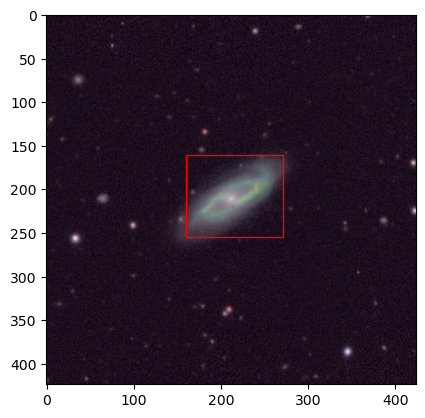

In [11]:
fig = plt.figure()

img = matplotlib.image.imread(DATA_PATH + df['desi_jpg_loc'].iloc[1441])
mask_bar = matplotlib.image.imread(DATA_PATH + df['bar_mask_loc'].iloc[1441])
mask_spiral = matplotlib.image.imread(DATA_PATH + df['spiral_mask_loc'].iloc[1441])

y1, y2, x1, x2 = bbox(mask_spiral)

r = matplotlib.patches.Rectangle(
    (x1, y1),
    x2-x1, y2-y1,
    facecolor='None', 
    edgecolor='r',
    ls='-',
    linewidth=1,
)
plt.gca().add_patch(r)
plt.imshow(img)
plt.imshow(mask_spiral, alpha=0.2)